Load dependencies

In [20]:
import scanpy as sc
import anndata as ad
import pandas as pd

Set settings and constants

In [21]:
sc.settings.set_figure_params(dpi=50, facecolor="white")
DATA_DIR = '/data/BIOL5177/Assessment'
SAMPLES = ['Infected1','Infected2','WT1']

Load in the data

In [22]:
# Returns an AnnData object which
def load_count_data_csv(data_dir, samples, counts_matrix = 'counts_matrix.csv', metadata = 'metadata.csv'):
    adata_dict = {}
    for sample_id in samples:
        print(sample_id)
        filepath = f'{data_dir}/{sample_id}/{counts_matrix}'
        a_filepath = f'{DATA_DIR}/WT1/{metadata}'
        counts_adata = sc.read(filepath)
        counts_adata = counts_adata.transpose()
        counts_adata.var_names_make_unique()
        
        #anno = pd.read_csv(a_filepath)
        #counts_adata.obs['nCount_RNA'] = anno['nCount_RNA']
        #counts_adata.obs['nFeature_RNA'] = anno['nFeature_RNA']
        #sample_adata.obs_names_make_unique()
        adata_dict[sample_id] = counts_adata
    
    adata = ad.concat(adata_dict, label="sample")
    #adata.obs_names_make_unique()
    
    return adata, adata_dict
    
    #return adata_dict

#adata = load_count_data_csv(DATA_DIR, SAMPLES)
adata, adata_dict = load_count_data_csv(DATA_DIR, SAMPLES)


Infected1
Infected2
WT1


Calculate QC metrics

In [23]:
adata.var["mt"] = adata.var_names.str.startswith("Mt")
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"], inplace=True, log1p=True)

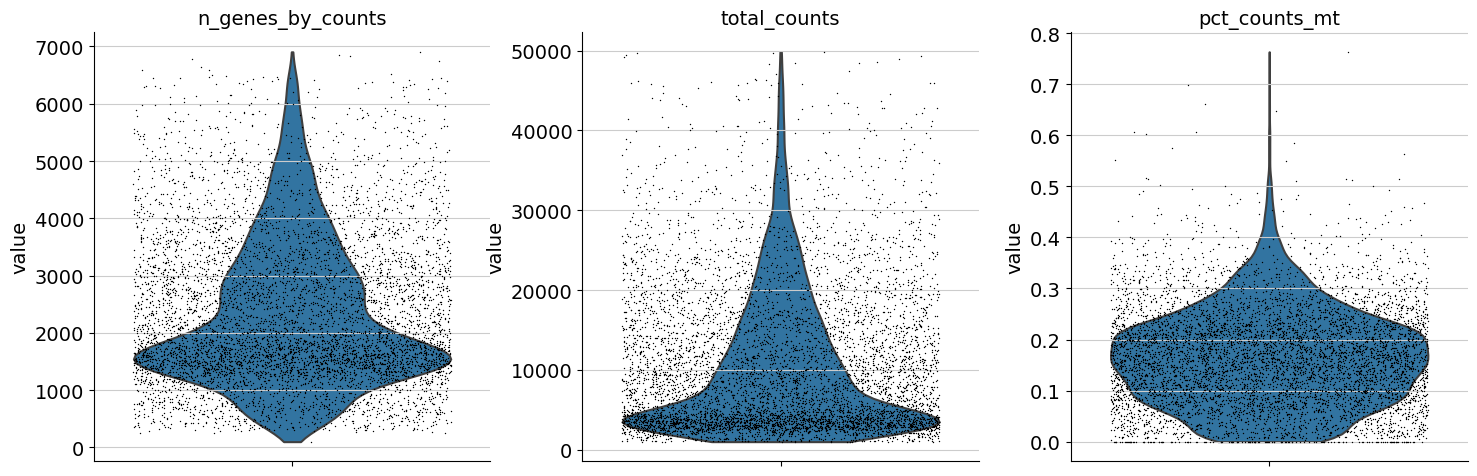

In [24]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

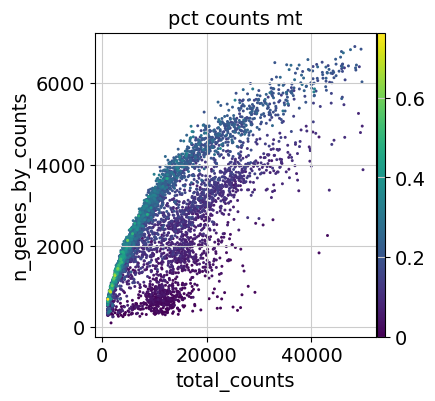

In [25]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Filter

In [26]:
def qc_filters(adata, min_genes=100, max_genes=2500, min_cells=3):
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_cells(adata, max_genes=2500)
    sc.pp.filter_genes(adata, min_cells=3)
    return adata
adata = qc_filters(adata)

Normalise data

In [27]:
def normalise_data(adata):
    adata.layers["counts"] = adata.X.copy()
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize
    sc.pp.log1p(adata)
    return adata

adata = normalise_data(adata)

Feature selection

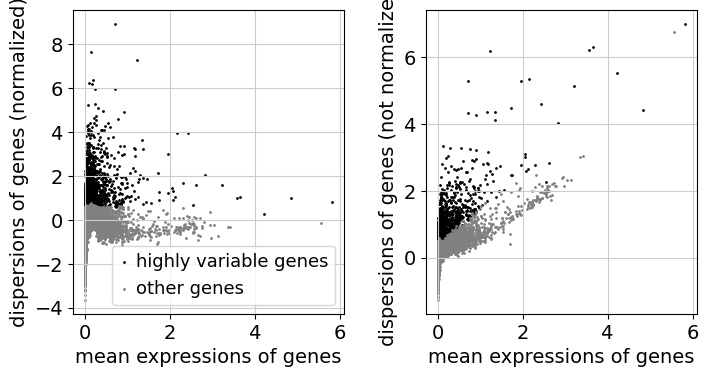

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

Scale data

In [29]:
sc.pp.scale(adata)

PCA

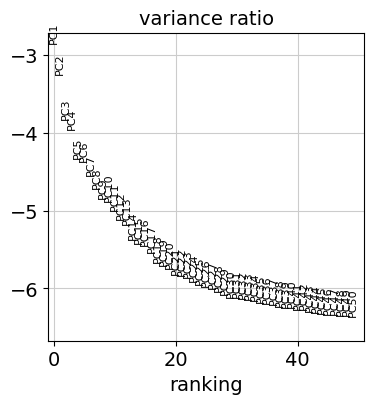

In [30]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

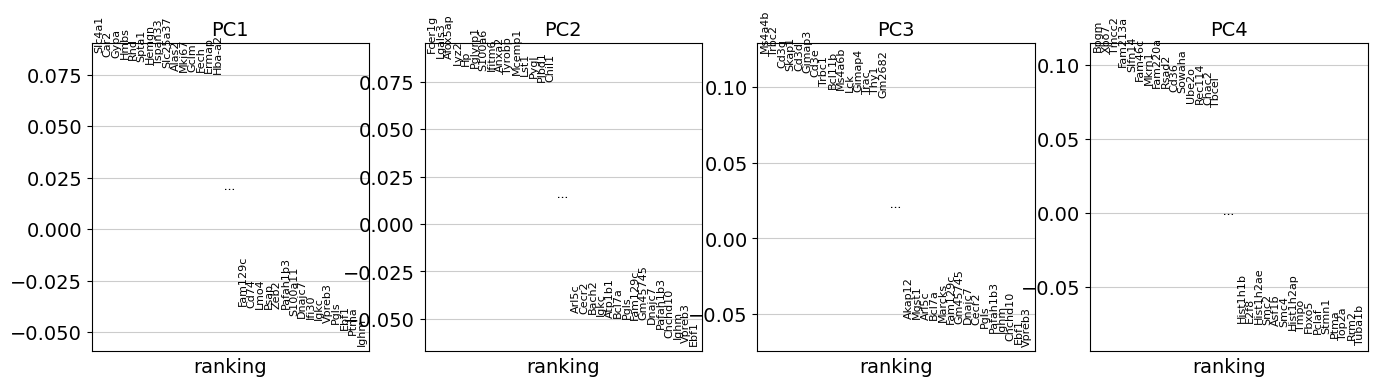

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


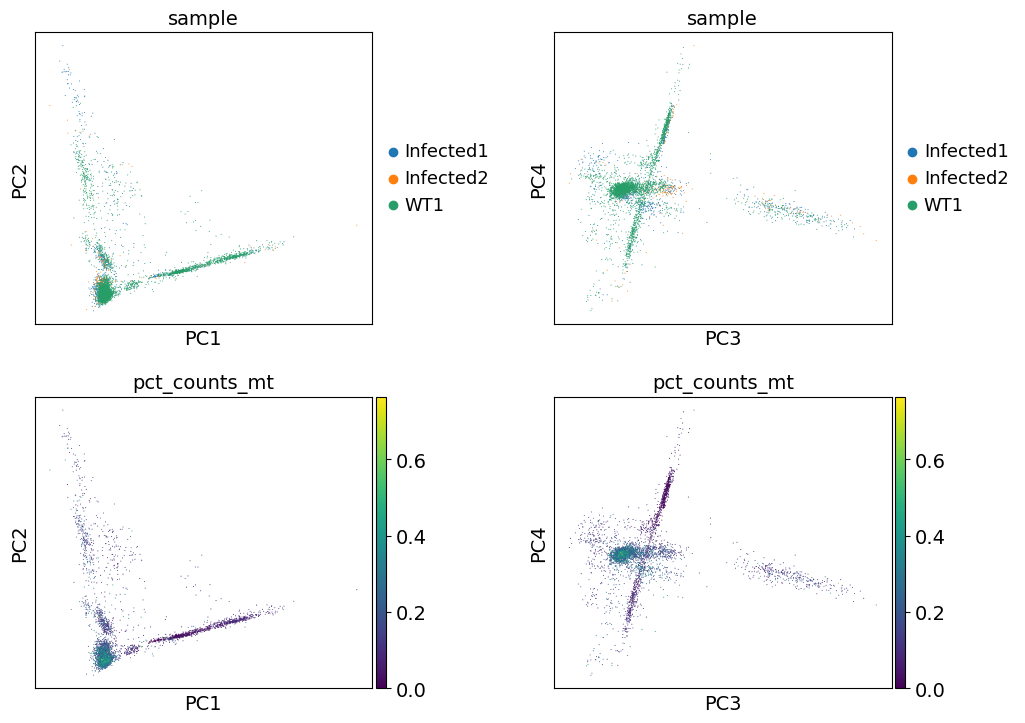

In [31]:
sc.pl.pca_loadings(adata, components = '1,2,3,4')
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    wspace=0.4,
)

UMAP

In [32]:
uninter_adata = adata.copy()
sc.pp.neighbors(uninter_adata, n_pcs=28)
sc.tl.umap(uninter_adata)

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


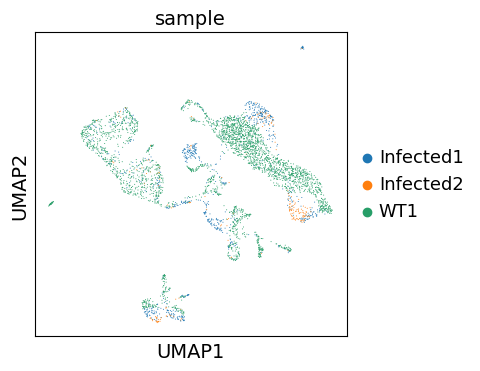

In [33]:
sc.pl.umap(
    uninter_adata,
    color="sample",
    size=2,
    return_fig=True
).savefig('./plots/umap.pdf', bbox_inches='tight')
#fig.savefig('test.png')

Integration

In [34]:
adata_integrated = adata.copy()
sc.external.pp.scanorama_integrate(adata_integrated, "sample")
#adata_integrated = sc.external.pp.bbknn(adata, batch_key="sample")

[[0.         0.89552239 0.81052632]
 [0.         0.         0.59701493]
 [0.         0.         0.        ]]
Processing datasets Infected1 <=> Infected2
Processing datasets Infected1 <=> WT1
Processing datasets Infected2 <=> WT1


/software/Anaconda3-2023.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


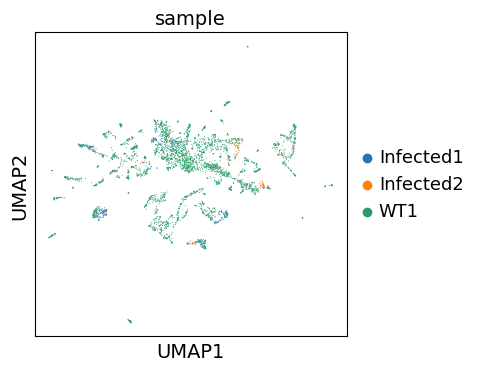

In [35]:
#print(adata_integrated)
#adata.obsm['X_scanorama']
sc.pp.neighbors(adata_integrated, use_rep="X_scanorama")
sc.tl.umap(adata_integrated)
sc.pl.umap(
    adata_integrated,
    color="sample",
    size=2,
    return_fig=True
).savefig('./plots/i_umap.pdf', bbox_inches='tight')

Clustering

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


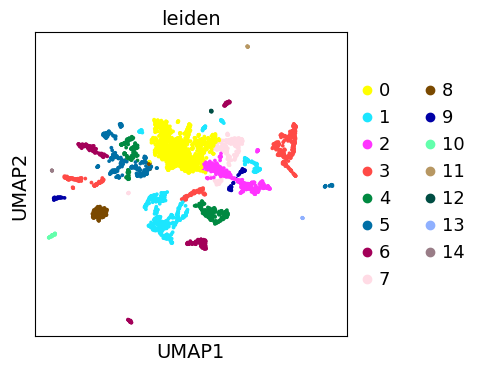

In [60]:
sc.tl.leiden(adata_integrated, resolution=0.1, n_iterations=-1) #sc.tl.leiden(adata_integrated, resolution=0.044, n_iterations=-1)
sc.pl.umap(adata_integrated, color=["leiden"], return_fig=True).savefig('./plots/i_umap_clusters.pdf', bbox_inches='tight')

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

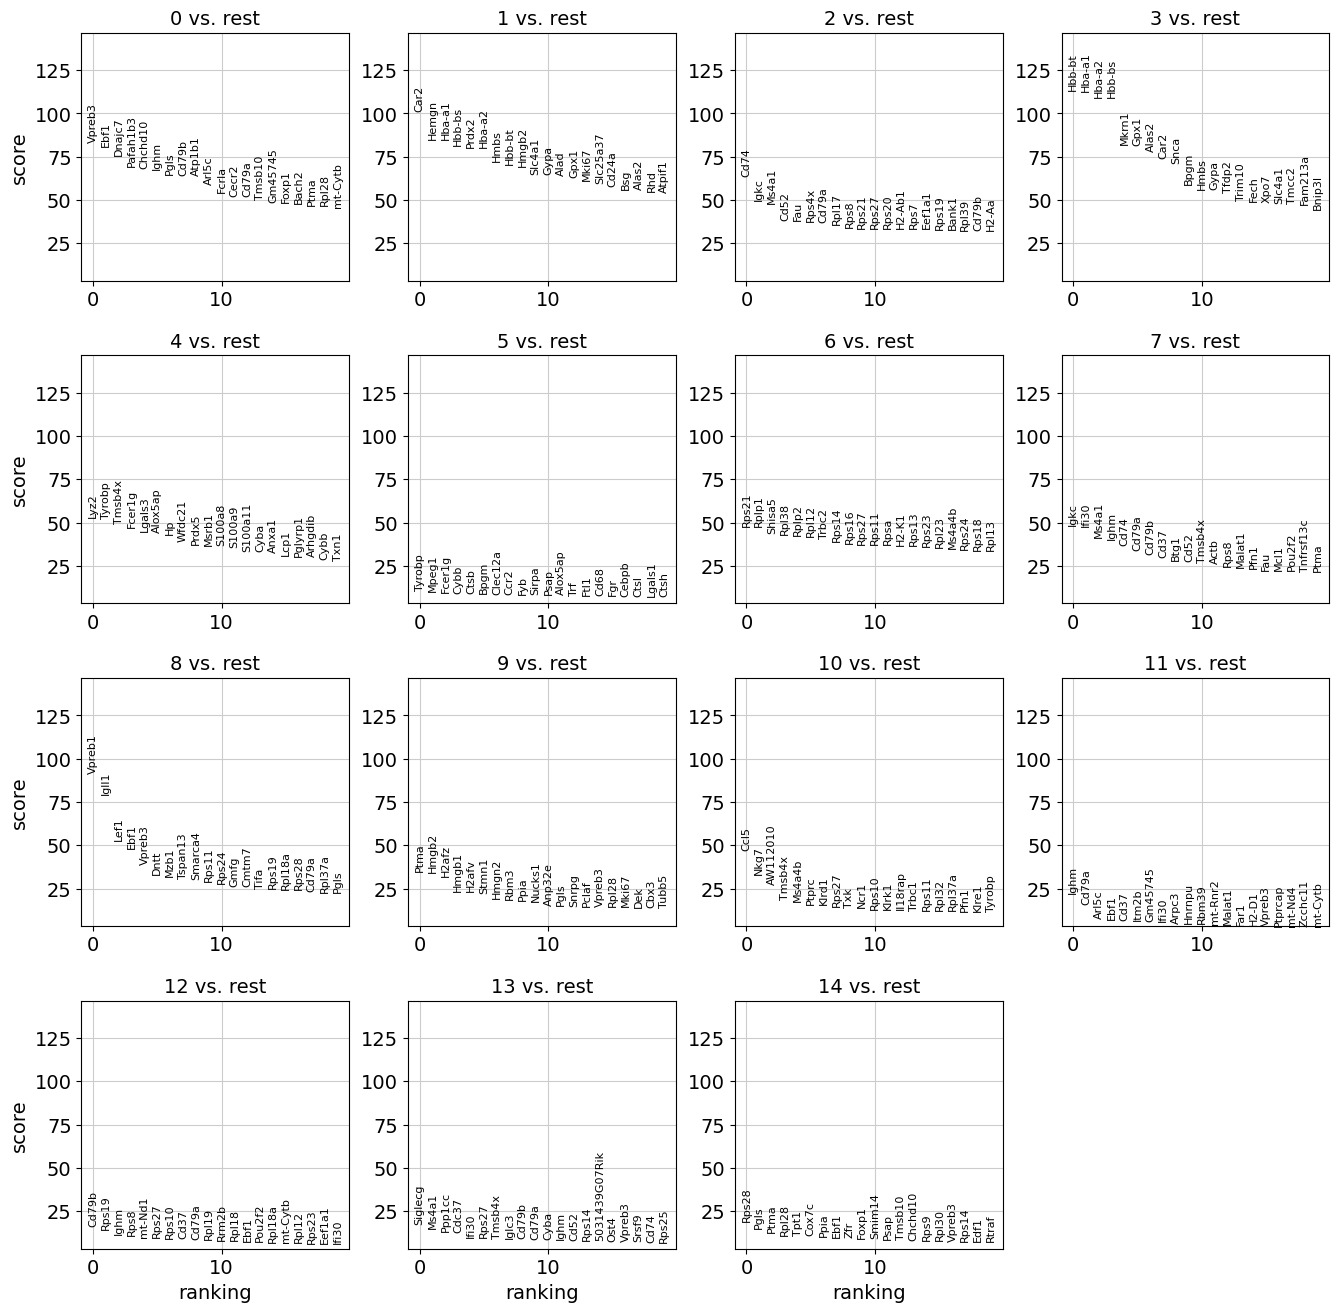

In [61]:
sc.tl.rank_genes_groups(adata_integrated, 'leiden')
sc.pl.rank_genes_groups(adata_integrated, save = True) #.savefig('./markers.pdf', bbox_inches='tight')
#adata_integrated.obs

In [76]:
#adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"]
adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"].map(
    {
        "0": "B Cells Cluster 1",
        "1": "Erythroid",
        "2": "B Cells Cluster 2",
        
    },na_action='ignore'
)

In [ ]:
"3": "3",
        "4": "4",
        "5": "5",
        "6": "6",
        "7": "7",
        "8": "8",
        "9": "9",
        "10": "10",
        "11": "11",
        "12": "12",
        "13": "13",
        "14": "14

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


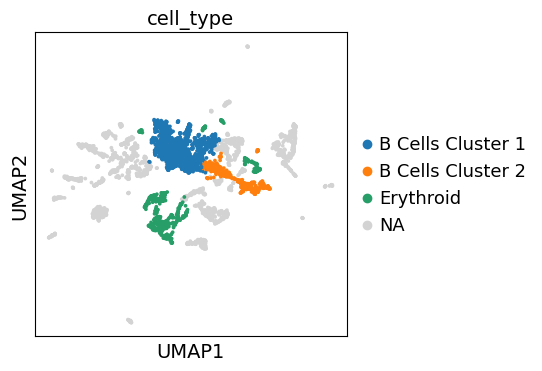

In [77]:
#adata_integrated.obs
#type(adata_integrated.obs["leiden"])
sc.pl.umap(adata_integrated, color=["cell_type"], return_fig=True).savefig('./plots/i_umap_clusters.pdf', bbox_inches='tight')

DE

In [84]:
# Get the cluster containing Ms4a1
b_cells_adata = adata_integrated[adata_integrated.obs['cell_type'] == 'B Cells Cluster 2',:]
b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({
        "WT1": "WT",
        "Infected1": "Infected",
        "Infected1": "Infected",
        
    },)

/tmp/ipykernel_1652785/4253382734.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({


In [85]:
b_cells_adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type,sample_type
TTTATGCTCGTCAAAC_4,Infected1,1552,7.347944,4377.0,8.384347,35.252456,48.823395,60.315284,75.713959,6.0,1.945910,0.137080,1552,2,B Cells Cluster 2,Infected
TCGGTCTCACCCTAAA_4,Infected1,1515,7.323831,3495.0,8.159375,30.100143,40.629471,52.646638,70.958512,6.0,1.945910,0.171674,1515,2,B Cells Cluster 2,Infected
TGAACGTAGAAGGTAG_4,Infected1,1525,7.330405,3673.0,8.209036,30.765042,43.860604,54.696433,72.093656,12.0,2.564949,0.326708,1525,2,B Cells Cluster 2,Infected
CCGATGGCAAATCGGG_4,Infected1,1707,7.443078,4763.0,8.468843,33.676254,47.785009,58.576527,73.147176,4.0,1.609438,0.083981,1707,2,B Cells Cluster 2,Infected
TAAGCACGTCGCTTGG_4,Infected1,1456,7.284135,3643.0,8.200837,33.571233,46.307988,56.684052,73.757892,8.0,2.197225,0.219599,1456,2,B Cells Cluster 2,Infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCATTTCCTCCACA_6,WT1,1753,7.469654,4292.0,8.364741,30.708295,42.684063,53.588071,69.221808,8.0,2.197225,0.186393,1753,2,B Cells Cluster 2,WT
CGCGTGACAATAGGGC_6,WT1,1241,7.124478,2817.0,7.943783,31.593894,44.160454,56.052538,73.695421,3.0,1.386294,0.106496,1241,2,B Cells Cluster 2,WT
TTCATTGGTCAACCAT_6,WT1,1780,7.484930,3846.0,8.255049,27.275091,37.831513,48.777951,65.496620,7.0,2.079442,0.182007,1780,2,B Cells Cluster 2,WT
ATGCGATAGGGCAACT_6,WT1,2280,7.732369,5688.0,8.646290,26.441632,38.150492,48.575949,63.326301,8.0,2.197225,0.140647,2280,2,B Cells Cluster 2,WT
